In [42]:
from typing import List, Tuple, Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

np.random.seed(32)

In [4]:
class Bandit:
    def __init__(self, mu: float, std: float, Q: float = 0.0, alpha: float = 0.1):
        self._mu = mu
        self._std = std
        self._Q = Q
        self._alpha = alpha

    def pull(self) -> float:
        return np.random.normal(loc=self._mu, scale=self._std)

    def update(self, r: float):
        self._Q += self._alpha * (r - self._Q)

    @property
    def true_mean(self):
        return self._mu

    @property
    def Q(self):
        return self._Q

In [ ]:
def single_run(
    bandits: List[Bandit], n_steps: int, eps: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    rewards = np.zeros(n_steps)
    optimals = np.zeros(n_steps)
    selected_actions = np.zeros(n_steps)

    optimal_bandit = int(np.argmax([b.true_mean for b in bandits]))
    for i in range(n_steps):
        if np.random.rand() < eps:
            bandit = np.random.choice(len(bandits))
        else:
            bandit = np.argmax([b.Q for b in bandits])

        bandit = int(bandit)
        r = bandits[bandit].pull()
        bandits[bandit].update(r)

        selected_actions[i] = bandit
        optimals[i] = 1 if bandit == optimal_bandit else 0
        rewards[i] = r

    return rewards, optimals, selected_actions

In [6]:
def run_experiment(
    true_means: np.ndarray,
    true_sigmas: np.ndarray,
    n_runs: int,
    n_steps: int,
    eps: float = 0.1,
    Q: float = 0.0,
    alpha: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    all_rewards = np.zeros((n_runs, n_steps))
    all_optimals = np.zeros((n_runs, n_steps))
    all_actions = np.zeros((n_runs, n_steps))

    for i in range(n_runs):
        bandits = [
            Bandit(mu=mu, std=sigma, Q=Q, alpha=alpha)
            for (mu, sigma) in zip(true_means, true_sigmas)
        ]
        rewards, optimals, actions = single_run(
            bandits=bandits, n_steps=n_steps, eps=eps
        )
        all_rewards[i] = rewards
        all_optimals[i] = optimals
        all_actions[i] = actions

    return all_rewards.mean(axis=0), all_optimals.mean(axis=0), all_actions

In [7]:
K = 10
MEANS = np.random.randn(K)
SIGMAS = np.random.rand(K)
N_RUNS = 2000
N_STEPS = 1000

In [8]:
exp_r, exp_o, exp_a = run_experiment(
    true_means=MEANS, true_sigmas=SIGMAS, n_runs=N_RUNS, n_steps=N_STEPS, eps=0.0, Q=5
)

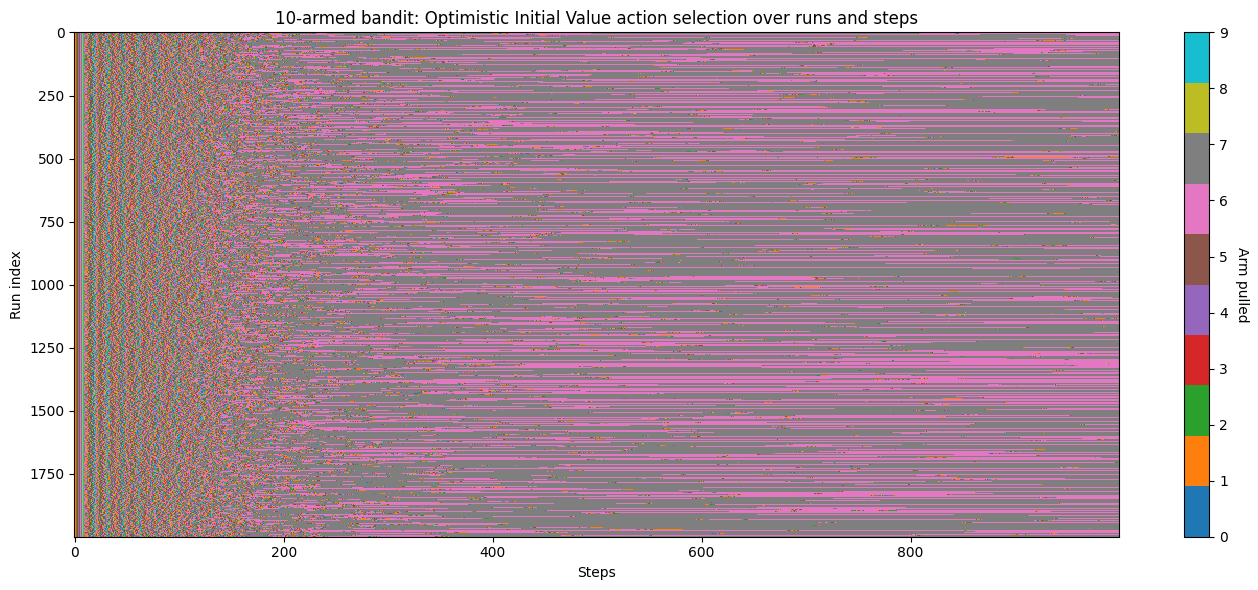

In [9]:
plt.figure(figsize=(14, 6))
cmap = plt.get_cmap("tab10", K)
img = plt.imshow(
    exp_a, aspect="auto", interpolation="nearest", cmap=cmap, vmin=0, vmax=K - 1
)
cbar = plt.colorbar(img, ticks=range(K))
cbar.set_label("Arm pulled", rotation=270, labelpad=15)

plt.xlabel("Steps")
plt.ylabel("Run index")
plt.title(
    "10-armed bandit: Optimistic Initial Value action selection over runs and steps"
)
plt.tight_layout()
plt.show()

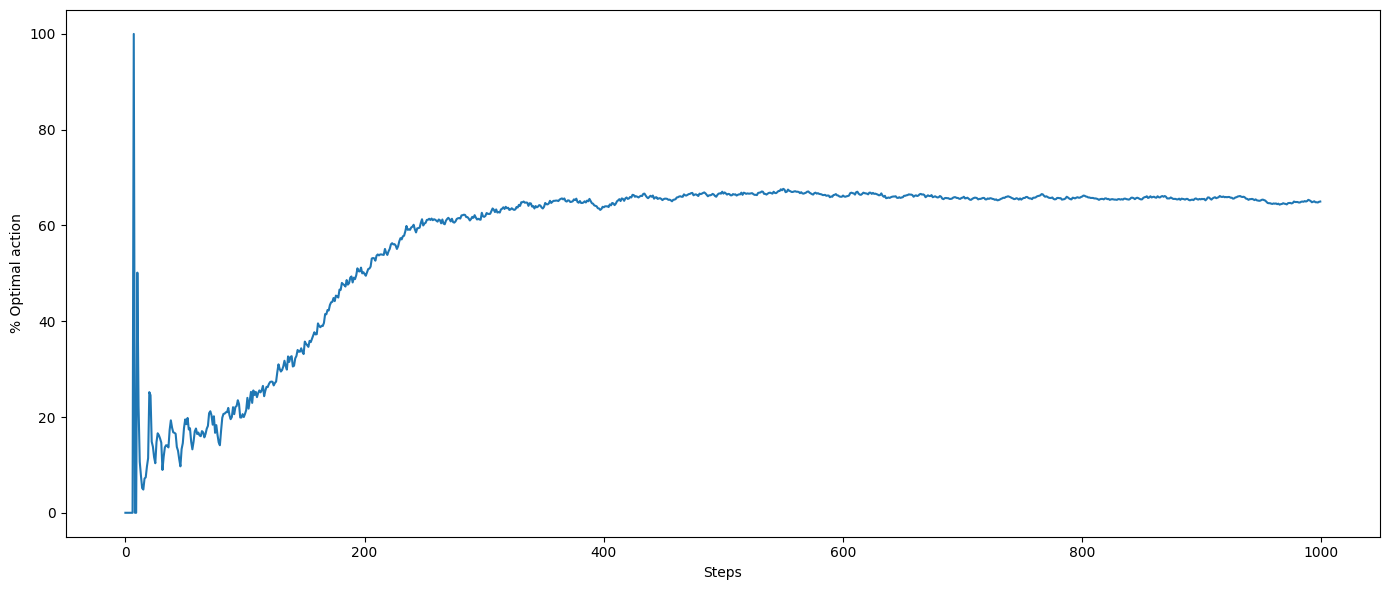

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(exp_o * 100)
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.tight_layout()
plt.show()

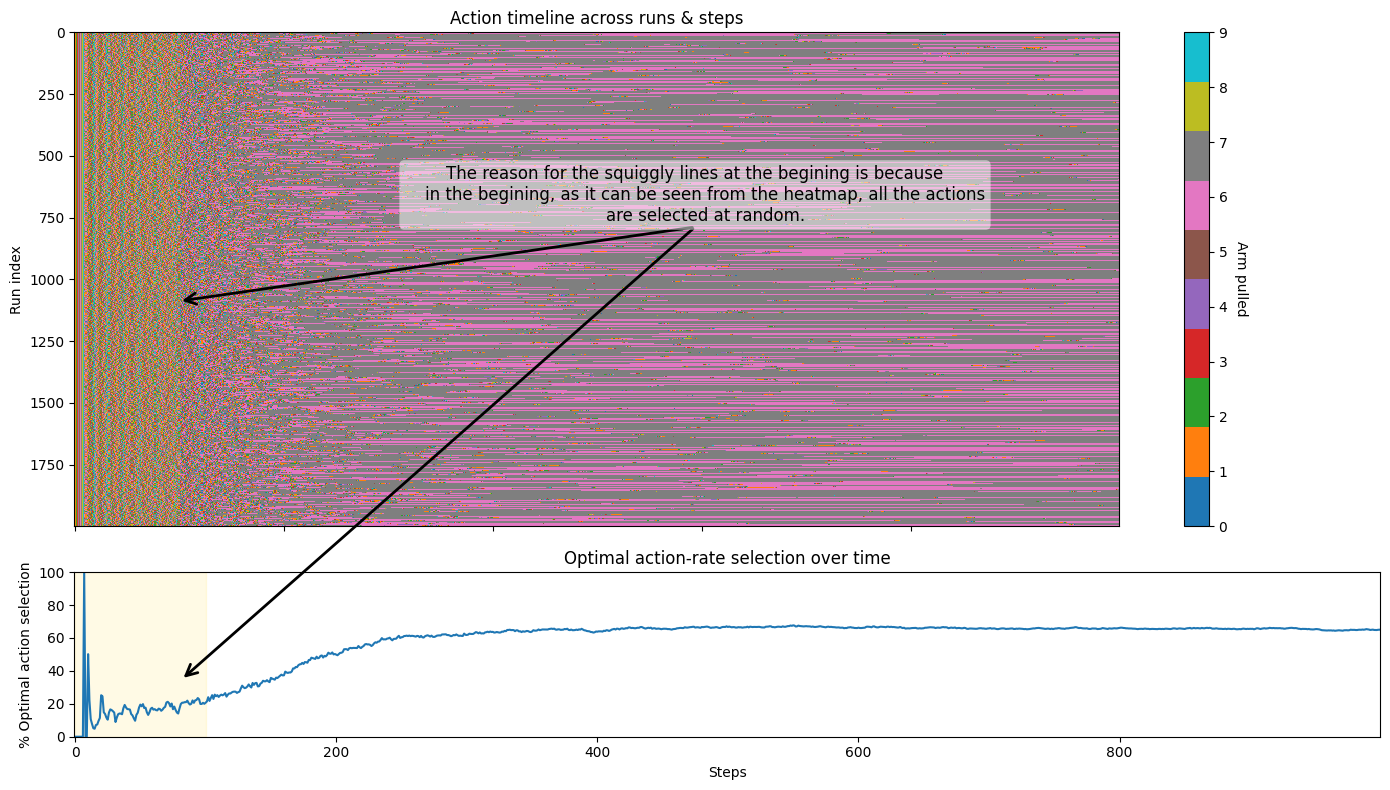

In [64]:
fig, ax = plt.subplots(
    2, 1, figsize=(14, 8), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
)
ax = ax.flatten()

cmap = plt.get_cmap("tab10", K)
img = ax[0].imshow(
    exp_a, aspect="auto", interpolation="nearest", cmap=cmap, vmin=0, vmax=K - 1
)

cbar = fig.colorbar(img, ax=ax[0], ticks=range(K), orientation="vertical")
cbar.set_label("Arm pulled", rotation=270, labelpad=15)
ax[0].set_ylabel("Run index")
ax[0].set_title("Action timeline across runs & steps")

ax[1].plot(exp_o * 100, lw=1.5)
ax[1].set_ylabel("% Optimal action selection")
ax[1].set_xlabel("Steps")
ax[1].set_ylim(0, 100)
ax[1].set_title("Optimal action-rate selection over time")

t0, t1 = 0, 100
for a in (ax[0], ax[1]):
    a.axvspan(t0, t1, color="gold", alpha=0.1)


mid_step = (t0 + t1) / 2
y0 = N_RUNS / 2  # halfway down the heatmap
y1 = exp_o[int(mid_step)] * 100  # the %‐optimal at that step

# 4) Place a single text label in figure‐fraction coords
label_x, label_y = 0.5, 0.75  # 50% across, 95% up the figure
margin = (t1 - t0) * 0.1  # 10 data‐units inside
arrow_x = t0 + margin
fig.text(
    label_x,
    label_y,
    """The reason for the squiggly lines at the begining is because
    in the begining, as it can be seen from the heatmap, all the actions
    are selected at random.""",
    ha="center",
    va="center",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="none", alpha=0.5),
)

# 5) Find those same (step, value) points in *figure* coords
target0 = fig.transFigure.inverted().transform(ax[0].transData.transform((arrow_x, y0)))
target1 = fig.transFigure.inverted().transform(ax[1].transData.transform((arrow_x, y1)))

# 6) Draw two arrows from the label down into each subplot
for tgt in (target0, target1):
    arrow = FancyArrowPatch(
        (label_x, label_y - 0.04),  # start just below the text
        tgt,  # end at the shaded region
        transform=fig.transFigure,
        arrowstyle="->",
        mutation_scale=20,  # arrow head size
        lw=2,
        color="black",
    )
    fig.add_artist(arrow)

plt.tight_layout()
plt.show()